<a href="https://colab.research.google.com/github/AaryanGotad/ml-practice/blob/main/predicting_student_test_scores/kaggle_playground_S6E1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Student test scores prediction using linear regression

This notebook analyzes the trend in student test scores and build a linear regression model to predict test scores based on various components.

## 1. Importing Required Libraries
Importing pandas, numpy, matplotlib, seaborn and sklearn libraries for data manipulation, visualisation and machine learning

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import warnings

warnings.filterwarnings('ignore')

# setting style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Learning about the dataset

Using `pandas` to load training and test datasets from CSV files, and get aware of the dataset

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")
print(f"Sample submission data shape: {sample_submission.shape}")

# Display first few rows of training data
print(f"\nFirst 5 rows of training data:")
train_df.head()

Training data shape: (630000, 13)
Testing data shape: (270000, 12)
Sample submission data shape: (270000, 2)

First 5 rows of training data:


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


## 3. Data Overview and Basic Information
Display basic information about the dataset including shape, data types and missing values using pandas methoda.

In [3]:
# Basic information about the dataset
print("Dataset Info:")
print(train_df.info())

print("\nDataset Description:")
print(train_df.describe())

print("\nMissing values in training data:")
print(train_df.isnull().sum())

print("\nMissing values in test data:")
print(test_df.isnull().sum())

print("\nColumn names:")
print(train_df.columns.tolist())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                630000 non-null  int64  
 1   age               630000 non-null  int64  
 2   gender            630000 non-null  object 
 3   course            630000 non-null  object 
 4   study_hours       630000 non-null  float64
 5   class_attendance  630000 non-null  float64
 6   internet_access   630000 non-null  object 
 7   sleep_hours       630000 non-null  float64
 8   sleep_quality     630000 non-null  object 
 9   study_method      630000 non-null  object 
 10  facility_rating   630000 non-null  object 
 11  exam_difficulty   630000 non-null  object 
 12  exam_score        630000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 62.5+ MB
None

Dataset Description:
                  id            age    study_hours  class_attenda

### Visualizing Distributions with Histograms

Histograms can visually show the shape of the data distribution, which helps in identifying skewness or normality.

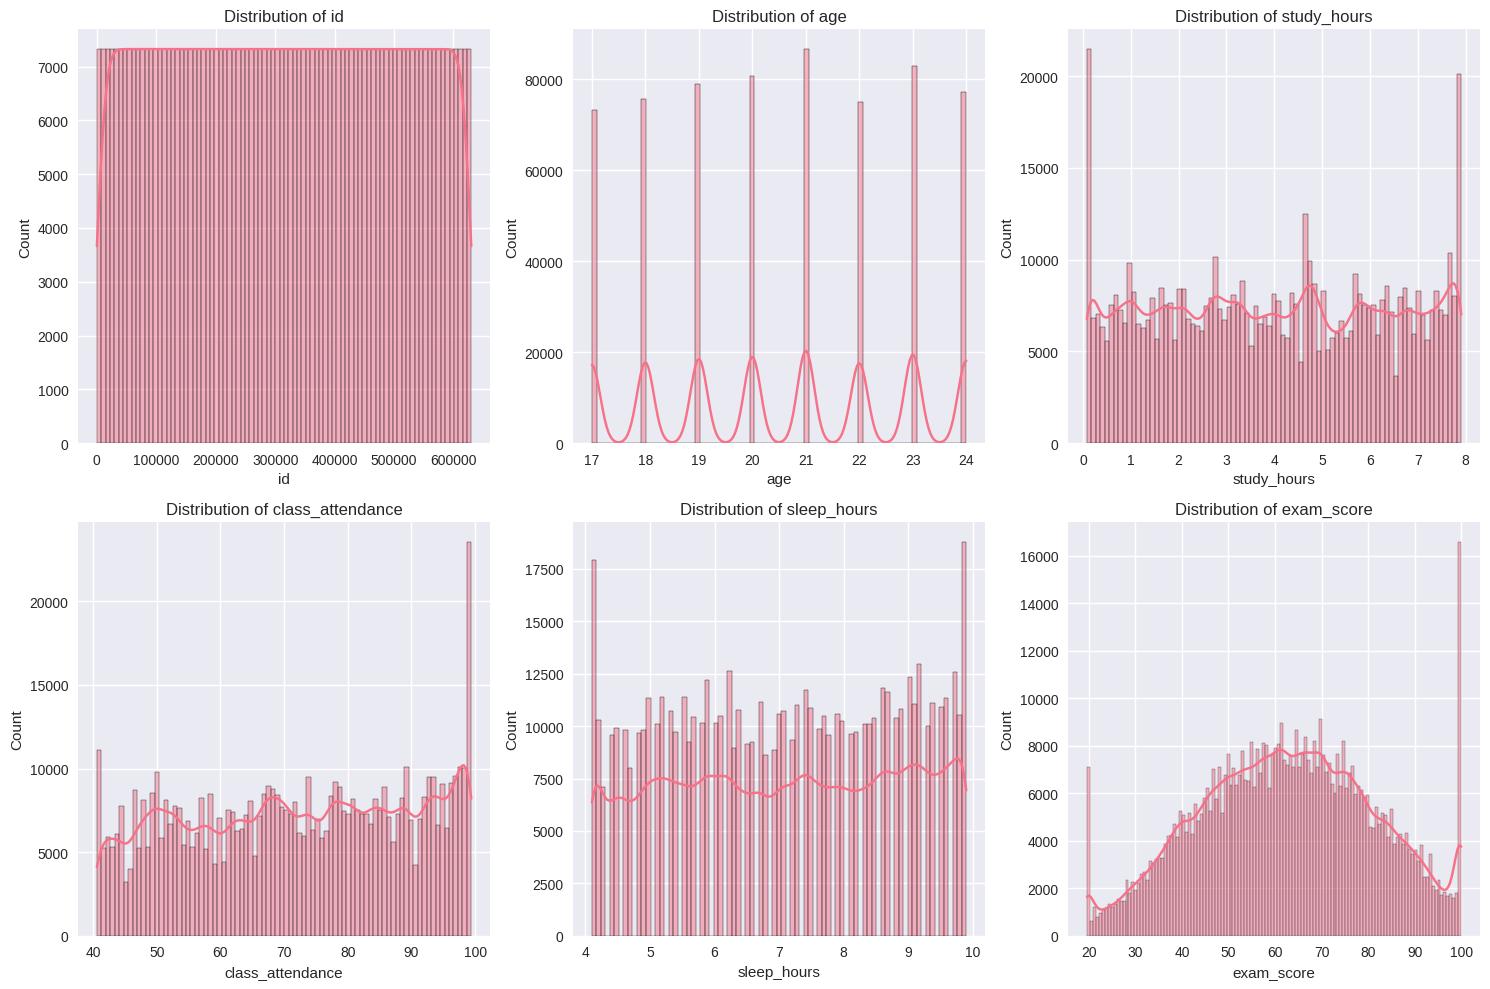

In [4]:
numerical_cols = train_df.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1) # Adjust subplot grid as needed
    sns.histplot(train_df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

### Quantile-Quantile (Q-Q) Plots for Normality Check

Q-Q plots compare the quantiles of your data to the quantiles of a theoretical normal distribution. If the data is normally distributed, the points will fall approximately along a straight line.

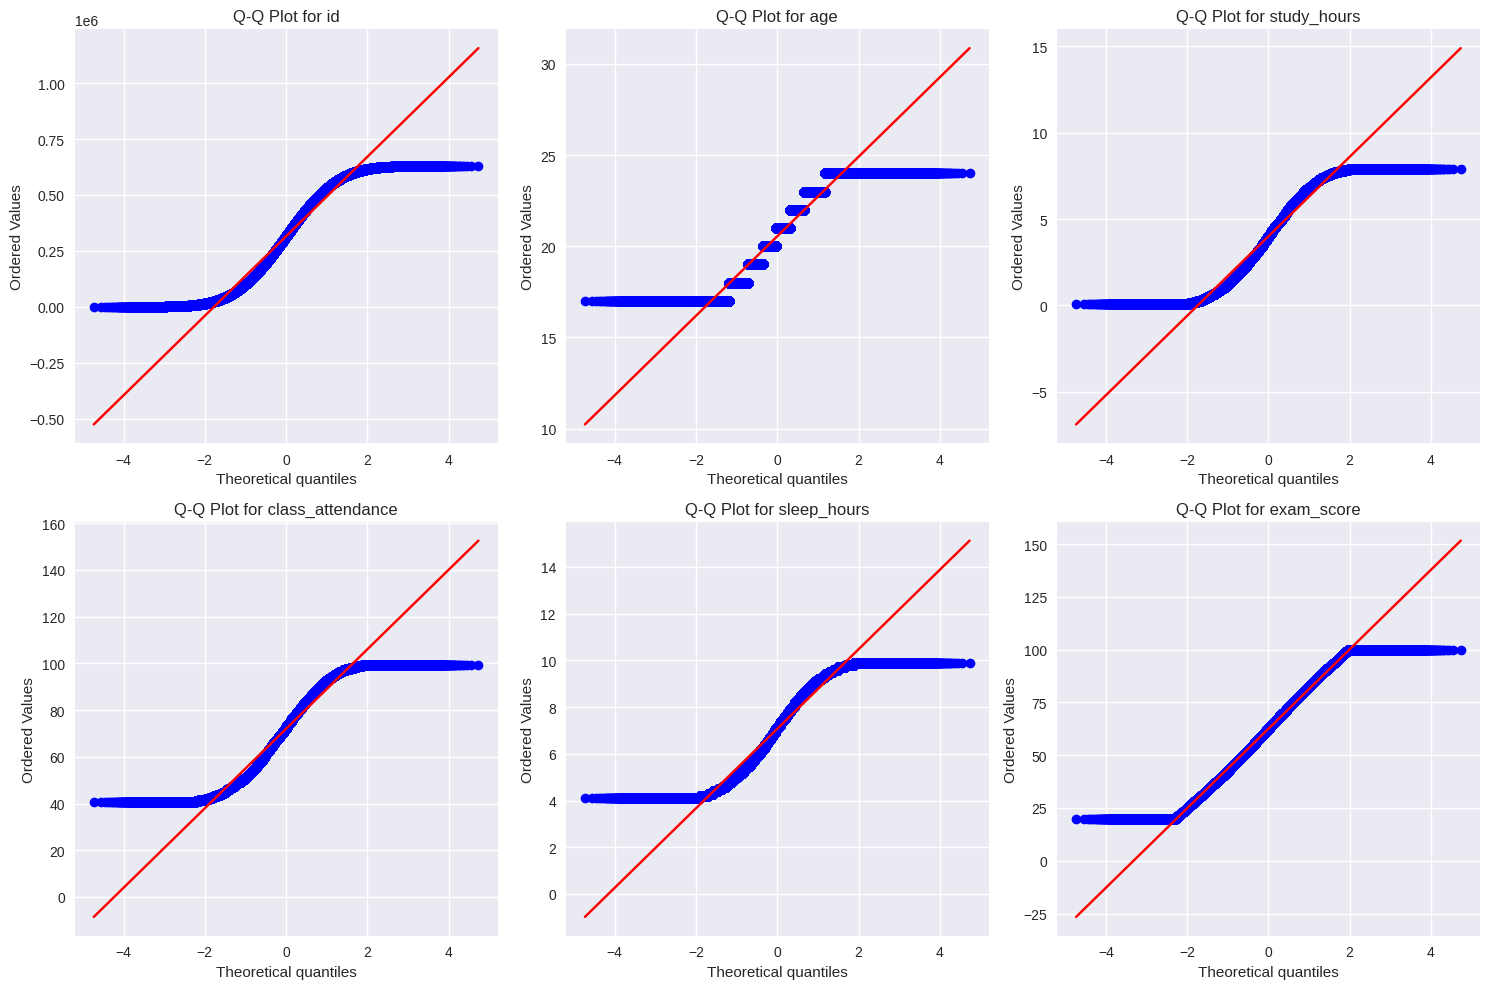

In [5]:
from scipy import stats

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1) # Adjust subplot grid as needed
    stats.probplot(train_df[col], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for {col}')
plt.tight_layout()
plt.show()

### Calculating Skewness Numerically

Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. A skewness value close to 0 indicates a symmetrical distribution (like a normal distribution). Positive values indicate a right (positive) skew, and negative values indicate a left (negative) skew.

In [6]:
print("Skewness of numerical columns in training data:")
print(train_df[numerical_cols].skew())

Skewness of numerical columns in training data:
id                 -1.954200e-15
age                -2.387784e-02
study_hours         8.931260e-03
class_attendance   -9.583166e-02
sleep_hours        -3.998608e-02
exam_score         -4.827320e-02
dtype: float64


## 3. Setting a Baseline

In [10]:
# Separating the features and target
X = train_df.drop(columns=["exam_score"])
y = train_df["exam_score"]

test_X = test_df.copy()

## Identifying categorical vs numerical columns programmatically

In [12]:
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

## Preprocessing pipeline

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(), categorical_cols)
    ]
)

## Model: Ridge Regression
Reasom for using Ridge regression model instead of Linear Regression:
* Ridge regression is a regularized linear regression model that adds a penalty term
* Has better generalization
* Will give us a stronger baseline to beat

In [14]:
model = Ridge(alpha=1.0, random_state=42)

Cross Validation loop

In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []

for train_idx, val_idx in kf.split(X):
  X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
  y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

  X_train_prep = preprocessor.fit_transform(X_train)
  X_val_prep = preprocessor.transform(X_val)

  model.fit(X_train_prep, y_train)
  preds = model.predict(X_val_prep)

  # Calculate MSE first, then take the square root for RMSE
  rmse = np.sqrt(mean_squared_error(y_val, preds))
  rmse_scores.append(rmse)

print("CV RMSE:", np.mean(rmse_scores))

CV RMSE: 8.894836865863487


## Submitting this as a baseline

First, I will fit preprocessing on full training data

In [19]:
X_prep = preprocessor.fit_transform(X)
test_prep = preprocessor.transform(test_X)

Training model on full data

In [20]:
model.fit(X_prep, y)

Ridge(random_state=42)

Predicting test set

In [21]:
test_preds = model.predict(test_prep)

Creating a submission file

In [23]:
submission = pd.DataFrame({
    "id": test_df["id"],
    "exam_score": test_preds
})

submission.to_csv("submission_phase2_ridge.csv", index=False)